In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
load_dotenv
import requests
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
dfml = pd.read_csv("dfinfo_apex_enriched.csv")
#El csv debe tener las columnas "['gold_diff', 'kill_diff', 'my_team_tower_fb','my_team_drake_fb','my_team_herald_fb', 'my_team_win']"
dfml.tail()

,gold_diff,kill_diff,my_team_tower_fb,my_team_drake_fb,my_team_herald_fb,my_team_win
1505,262,1,0,0,0,True
1506,-623,-4,1,0,0,False
1507,1103,2,1,0,1,True
1508,-223,0,0,1,1,True
1509,1775,2,1,1,1,False


In [3]:

X = dfml.drop(columns='my_team_win')
y = dfml['my_team_win']

# División en entrenamiento y prueba (oro real todavía aquí)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ------------------------------
# Escalar SOLO con entrenamiento
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a DataFrame manteniendo índices y columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

#X_train = pd.DataFrame(X_train, columns=X.columns, index=X_train.index)
#X_test = pd.DataFrame(X_test, columns=X.columns, index=X_test.index)

In [ ]:
model_enriched = LogisticRegression(
    penalty='l1',    # l2 es default
    C=0.1,           # higher C = menos regularización
    solver='saga',   # lbfgs para l2, saga soporta l1
    random_state=42,
    max_iter=10000,
    fit_intercept=True
)
model_enriched.fit(X_train_scaled, y_train)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,7
,solver,'saga'
,max_iter,10000
,multi_class,'deprecated'


In [5]:
y_proba = model_enriched.predict_proba(X_test_scaled)[:, 1]  # prob. de clase 1
new_threshold = 0.5
y_pred_adjusted = (y_proba >= new_threshold).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_adjusted))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))
print("\nClassification Report:\n", classification_report(y_test, y_pred_adjusted))

Accuracy: 0.7549668874172185

Confusion Matrix:
 [[ 97  41]
 [ 33 131]]

Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.70      0.72       138
        True       0.76      0.80      0.78       164

    accuracy                           0.75       302
   macro avg       0.75      0.75      0.75       302
weighted avg       0.75      0.75      0.75       302



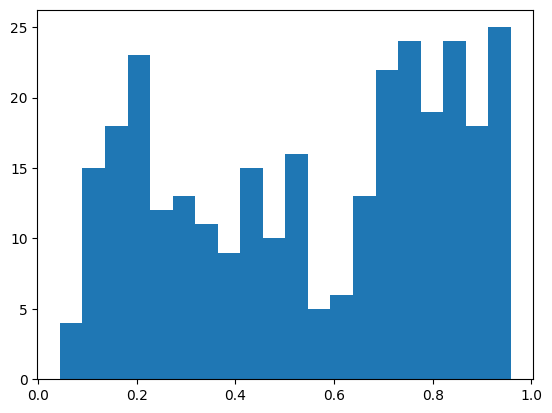

In [6]:
import matplotlib.pyplot as plt
plt.hist(y_proba, bins=20); plt.show()

In [ ]:
# Probabilidades de victoria para el conjunto de prueba
df = pd.read_csv('predicts_csv.csv')
X_pred = df[features]
X_pred_scaled = scaler.transform(X_pred)
probs = model_enriched.predict_proba(X_pred_scaled)[:, 1]  # ✅


# Imprimir la primera predicción de ejemplo:
for i in range(7):
    print(f"Ejemplo {i+1}: Probabilidad de ganar = {probs[i][1]*100:.2f}%")

Ejemplo 1: Probabilidad de ganar = 88.83%
Ejemplo 2: Probabilidad de ganar = 69.89%
Ejemplo 3: Probabilidad de ganar = 88.71%
Ejemplo 4: Probabilidad de ganar = 87.80%
Ejemplo 5: Probabilidad de ganar = 33.61%
Ejemplo 6: Probabilidad de ganar = 73.45%
Ejemplo 7: Probabilidad de ganar = 86.63%


In [7]:

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_enriched.coef_[0]
})

print(coef_df.sort_values(by='Coefficient', ascending=False))


             Feature  Coefficient
0          gold_diff     0.498733
4  my_team_herald_fb     0.491930
3   my_team_drake_fb     0.302893
1          kill_diff     0.180768
2   my_team_tower_fb    -0.643588


Una vez conformes con los resultados del ML se pueden tomar nuevos datos y predecir en base a lo que se ha entrenado el algoritmo.

Lo más importante de los siguientes bloques es la información contenida en "predicted_matches", aquí se almacenan las partidas que serán sometidas a predicción. Puede ser llenado a mano o utilizar la función "get_matchids" para obtener una serie continua de partidas del jugador. 

Se cual sea la metodología, con estas partidas se genera un nuevo dfinfo que es el input para predecir.

In [ ]:
gameName = 'Natanaël%20Cano'  #El %20 indica un espacio
tagLine = 'NATA'
api_key = os.getenv('RIOT_API_KEY')
predicts_csv = 'predicts_csv.csv'
matchtype = 'ranked'
queueid = '420' #Default para SoloQ
start = '0'
count = '5'

In [ ]:
from functions import get_df_data, get_puuid, get_matchids
puuid = get_puuid(gameName=gameName, tagLine=tagLine, api_key=api_key)

predicted_matches = get_matchids(puuid=puuid, queueid=queueid, matchtype=matchtype, start=start, count=count, api_key=api_key)
print(predicted_matches)

#predicted_matches=['','','']

['LA1_1642972444', 'LA1_1642962195', 'LA1_1642710668', 'LA1_1642704329', 'LA1_1642695796']


In [10]:
df = pd.DataFrame(get_df_data(history = predicted_matches, puuid = puuid, api_key = api_key, csv_path = predicts_csv))
df.to_csv(predicts_csv, index=False)

[LA1_1642972444] Ya estaba registrado, se omite.
[LA1_1642962195] Ya estaba registrado, se omite.
[LA1_1642710668] Ya estaba registrado, se omite.
[LA1_1642704329] Ya estaba registrado, se omite.
[LA1_1642695796] Ya estaba registrado, se omite.


In [ ]:
# Asumiendo que ya generaste df con get_df_data y lo cargaste
df = pd.read_csv('predicts_csv.csv')

# 1) Crear columnas binarias FB (igual que en entrenamiento)
for col in ['tower_fb', 'drake_fb', 'herald_fb']:
    if col in df.columns:
        df[f'my_team_{col}_fb'] = (df[col] == df['my_team']).astype(int)
    else:
        raise ValueError(f"Falta la columna {col} en df para construir 'my_team_{col}_fb'.")

# 2) Seleccionar features EXACTAS del entrenamiento
features = ['gold_diff', 'kill_diff',
            'my_team_tower_fb','my_team_drake_fb','my_team_herald_fb']

# Validación rápida de columnas
missing = [c for c in features if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas para predecir: {missing}")

X_pred = df[features]

# 3) Escalar con el MISMO scaler ya fit en train
X_pred_scaled = scaler.transform(X_pred)

# 4) Predecir probabilidades con el modelo entrenado
probs = model_enriched.predict_proba(X_pred_scaled)[:, 1]

# 5) Armar resultados
results = pd.DataFrame({
    "match_id": df["match_id"],
    "prob_victoria": probs
})
print(results.sort_values("prob_victoria", ascending=False).head(10))


In [ ]:


features = ['gold_diff', 'kill_diff', 'my_team_tower_fb', 'my_team_drake_fb', 'my_team_herald_fb']

match_ids = df['match_id']
X_pred = df[features]

In [ ]:
X_pred_scaled = scaler.transform(X_pred)
probs = model_enriched.predict_proba(X_pred_scaled)[:, 1]
results = pd.DataFrame({"match_id": match_ids, "prob_victoria": probs})
print(results)

         match_id  prob_victoria
0  LA1_1642972444       0.325888
1  LA1_1642962195       0.388039
2  LA1_1642710668       0.386514
3  LA1_1642704329       0.537351
4  LA1_1642695796       0.541418


c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_it

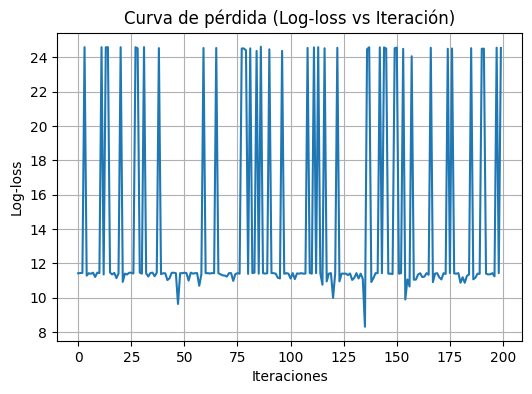

In [9]:
from functions import plot_loss_curve, plot_entropy_vs_diff, plot_calibration_curve, plot_roc_curve
plot_loss_curve(X_train, y_train, max_iter=200)

Matemáticamente 

$logit = log(p / (1-p)) = log-odds = b_0 + b_1 x_1 + ...$

y al normalizar, 

$s = b_0 + \omega _1 \frac{x_1 - \mu _1}{\sigma _1} + \omega _1 \frac{x_2 - \mu _2}{\sigma _2} + ... $

siendo $\mu _j$ la media, $\sigma _j$ la desviación estándar y $\omega _j$ los pesos, es decir, los coeficientes calculados

Esta representación también se puede interpretar como un vector $\bar \omega$ y otro  $\bar z$, donde $\omega$ guarda los pesos y $z$ guarda los valores estandarizados

$p = \sigma (b_o + \bar \omega ^ T \bar z )$

In [ ]:
import numpy as np

# Intercepto
intercept = model_enriched.intercept_[0]

# Coeficientes
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_enriched.coef_[0]
})

# Construir la ecuación como string
terms = [f"{row['Coefficient']:.3f}·{row['Feature']}" 
         for _, row in coef_df.iterrows()]
equation_str = " + ".join(terms)
equation_str = f"logit(p) = {intercept:.3f} + " + equation_str

print("Ecuación logística")
print(equation_str)
print("\nProbabilidad de victoria:")
print("p = 1 / (1 + exp(-logit(p)))")



=== Ecuación logística ===
logit(p) = 0.237 + 0.499·gold_diff + 0.181·kill_diff + -0.644·my_team_tower_fb + 0.303·my_team_drake_fb + 0.492·my_team_herald_fb

Probabilidad de victoria:
p = 1 / (1 + exp(-logit(p)))


La siguiente gráfica muestra el histograma y la función de "densidad de probabilidad" asignada por el modelo (no confundir con la función ..., que es la que usa el modelo para predecir victoria o derrota), es decir, muestra los valores de probabilidad de victoria más usados por el modelo. Al ver la doble campana en valores alejados del centro, nos dice que tiene buena confianza en las decisiones que toma.

En cuanto a los momentos de orden 1 y 2, la media en 0.55 indica que el modelo es más propenso a predecir victoria, mientras que la varianza de 0.0765 indica que los valores están dispersos entre 0 y 1, lo cual se ajusta a lo que buscamos, dado que no queremos apelotonamientos en ninguna parte

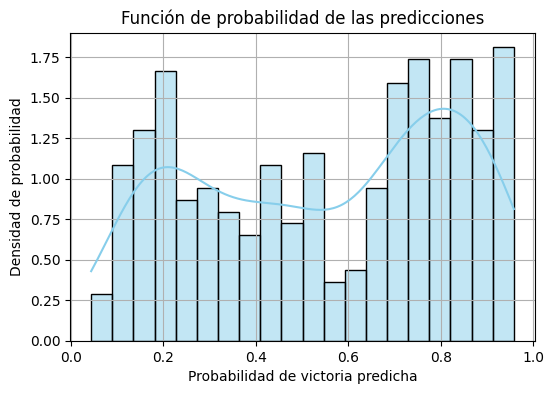

Momento 1 (media): 0.5525
Momento 2 (varianza): 0.0765


In [11]:
# Probabilidades predichas por el modelo
y_proba = model_enriched.predict_proba(X_test_scaled)[:, 1]

# Histograma normalizado (función de probabilidad empírica)
plt.figure(figsize=(6,4))
sns.histplot(y_proba, bins=20, kde=True, stat="density", color="skyblue", edgecolor="black")
plt.xlabel("Probabilidad de victoria predicha")
plt.ylabel("Densidad de probabilidad")
plt.title("Función de probabilidad de las predicciones")
plt.grid(True)
plt.show()

mean_prob = np.mean(y_proba)      # Momento 1
var_prob = np.var(y_proba)        # Momento 2

print(f"Momento 1 (media): {mean_prob:.4f}")
print(f"Momento 2 (varianza): {var_prob:.4f}")

La siguiente entropía es una sin binning, por lo tanto se muestra más "inconsistente"


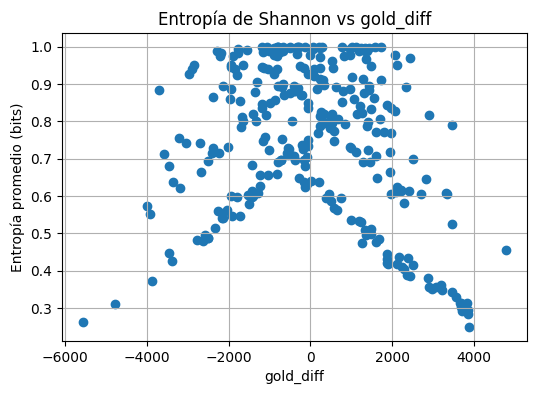

In [10]:
plot_entropy_vs_diff(model_enriched, X_test_scaled, dfml.loc[X_test.index], diff_col="gold_diff")

c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


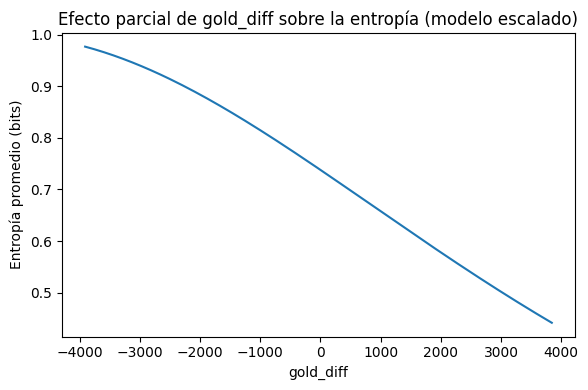

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from functions import entropy_bits

# 1) Punto de referencia: fijamos otras features en su mediana (espacio original, SIN escalar)
features = ['gold_diff','kill_diff','my_team_tower_fb','my_team_drake_fb','my_team_herald_fb']  # ajusta si difiere
ref = X_test.copy()
ref = ref[features].median().to_frame().T  # 1 fila con medianas

# 2) Barrido en gold_diff (en espacio original), manteniendo el resto fijo
gmin, gmax = X_test['gold_diff'].quantile([0.01, 0.99])
grid = np.linspace(gmin, gmax, 150)
grid_df = pd.concat([ref]*len(grid), ignore_index=True)
grid_df['gold_diff'] = grid

# 3) Escalar con el MISMO scaler y predecir
grid_sc = scaler.transform(grid_df[features])
p = model_enriched.predict_proba(grid_sc)[:,1]
H = entropy_bits(p)

# 4) Plot suave del efecto parcial
plt.figure(figsize=(6,4))
plt.plot(grid, H)
plt.xlabel('gold_diff')
plt.ylabel('Entropía promedio (bits)')
plt.title('Efecto parcial de gold_diff sobre la entropía (modelo escalado)')
plt.tight_layout()
plt.show()

c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarnin

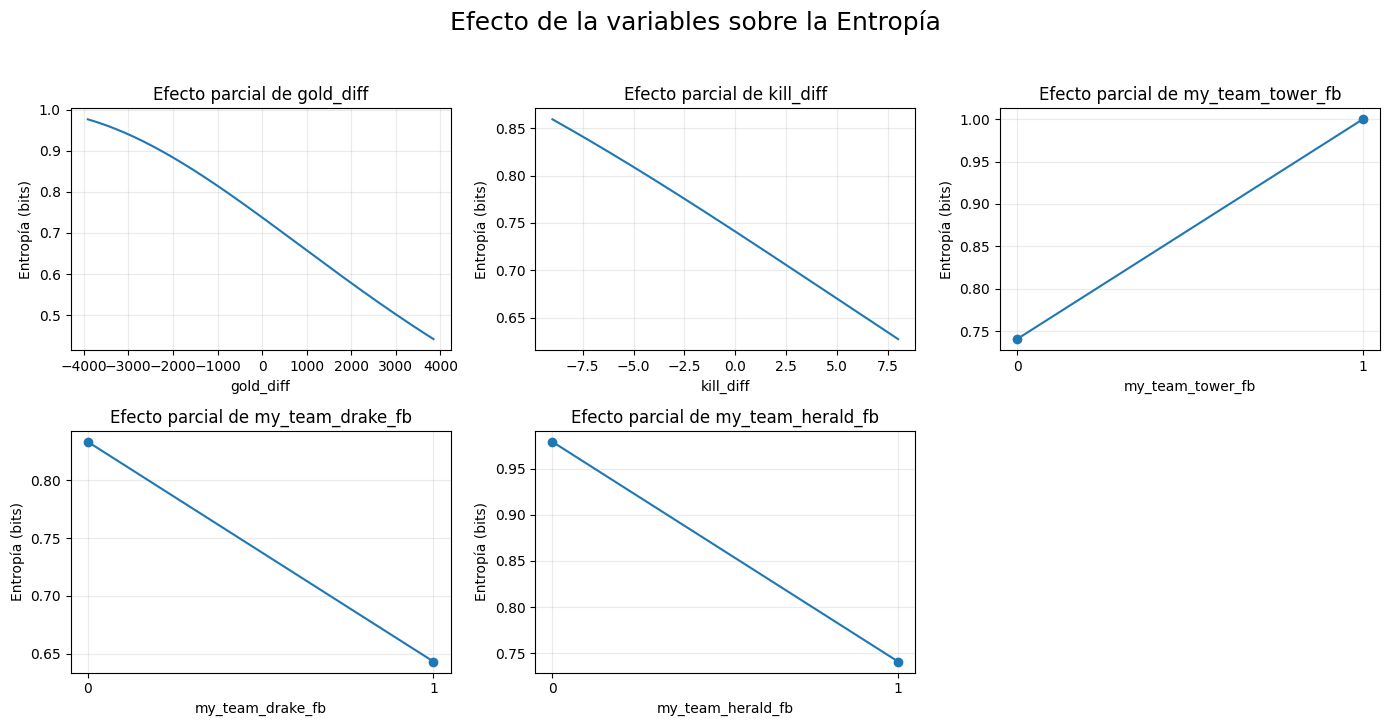

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from functions import is_binary, partial_entropy_curve

features = [
    'gold_diff', 'kill_diff',
    'my_team_tower_fb', 'my_team_drake_fb', 'my_team_herald_fb'
]


n = len(features)
rows = 2
cols = 3  # deja un hueco

fig, axes = plt.subplots(rows, cols, figsize=(14, 7))
axes = axes.flatten()

for i, feat in enumerate(features):
    xs, H = partial_entropy_curve(model_enriched, scaler, X_test, feat, features)

    ax = axes[i]
    if is_binary(feat, X_test):
        # Marcas en 0 y 1
        ax.plot(xs, H, marker='o')
        ax.set_xticks([0,1])
        ax.set_xticklabels(['0','1'])
    else:
        ax.plot(xs, H)

    ax.set_title(f'Efecto parcial de {feat}')
    ax.set_xlabel(feat)
    ax.set_ylabel('Entropía (bits)')
    ax.grid(True, alpha=0.25)

# Oculta el subplot sobrante si lo hay
if n < rows*cols:
    for j in range(n, rows*cols):
        fig.delaxes(axes[j])

fig.suptitle('Efecto de la variables sobre la Entropía', fontsize=18, y=1.03)
plt.tight_layout()
plt.show()

c:\Users\eeeli\OneDrive\Documentos\workspace\Learning RIOT API\1st lesson\functions.py:638: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(bins)['my_team_win']
c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


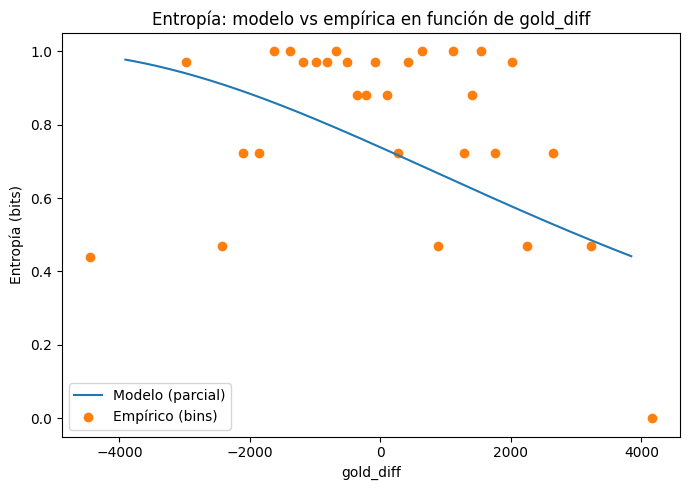

In [12]:
from functions import empirical_entropy_vs_gold, entropy_bits

# Calculamos entropía empírica en test set
xs_emp, H_emp = empirical_entropy_vs_gold(dfml.loc[X_test.index], n_bins=30)

# === 2) Curva parcial del modelo (como antes) ===
features = ['gold_diff','kill_diff','my_team_tower_fb','my_team_drake_fb','my_team_herald_fb']
ref = X_test[features].median().to_frame().T
gmin, gmax = X_test['gold_diff'].quantile([0.01, 0.99])
grid = np.linspace(gmin, gmax, 150)
grid_df = pd.concat([ref]*len(grid), ignore_index=True)
grid_df['gold_diff'] = grid

grid_sc = scaler.transform(grid_df[features])
p_model = model_enriched.predict_proba(grid_sc)[:, 1]
H_model = entropy_bits(p_model)

# === 3) Graficar comparativo ===
plt.figure(figsize=(7,5))
plt.plot(grid, H_model, label="Modelo (parcial)", color="C0")
plt.scatter(xs_emp, H_emp, label="Empírico (bins)", color="C1", marker="o")
plt.xlabel("gold_diff")
plt.ylabel("Entropía (bits)")
plt.title("Entropía: modelo vs empírica en función de gold_diff")
plt.legend()
plt.tight_layout()
plt.show()

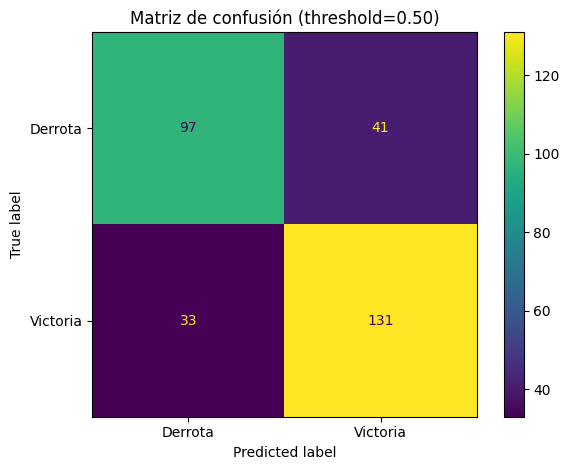

              precision    recall  f1-score   support

       False      0.746     0.703     0.724       138
        True      0.762     0.799     0.780       164

    accuracy                          0.755       302
   macro avg      0.754     0.751     0.752       302
weighted avg      0.755     0.755     0.754       302



In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_proba = model_enriched.predict_proba(X_test_scaled)[:, 1]

thr = 0.5  # ajusta si quieres
y_pred = (y_proba >= thr).astype(int)

cm = confusion_matrix(y_test, y_pred, labels=[0,1])

disp = ConfusionMatrixDisplay(cm, display_labels=['Derrota','Victoria'])
disp.plot(values_format='d')
plt.title(f"Matriz de confusión (threshold={thr:.2f})")
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred, digits=3))


La siguiente gráfica retrata la entropía en un escenario general. Se aprecia que la línea del modelo de regresión logística nunca cruza el umbral de 50%, lo cual indica, según el análisis de las variables, que la diferencia de oro, por sí sola, no es suficiente para determinar si una partida se pierde o no. Es un poderoso determinante de victoria, pero la derrota será decidida por los otros factores de peso.

Nota: el punto de inflexión p=0.5 está fuera del rango mostrado: -5350.0. Amplía 'grid' si quieres visualizarlo.


c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


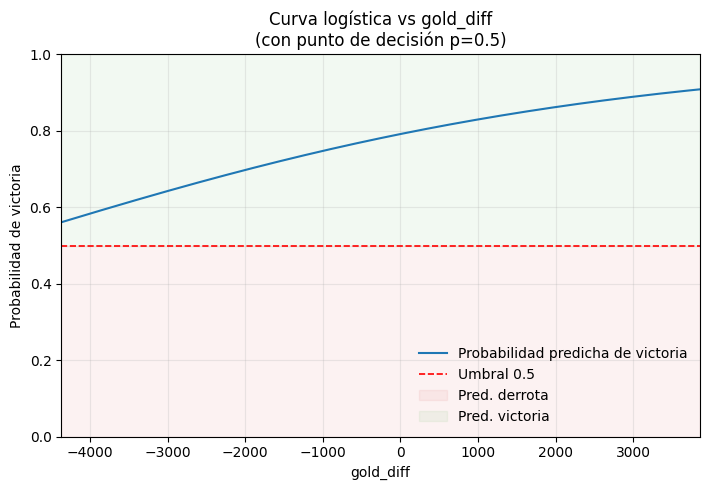

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Configuración ===
feature = 'gold_diff'
features = ['gold_diff','kill_diff','my_team_tower_fb','my_team_drake_fb','my_team_herald_fb']  # ajusta si difiere

# 1) Punto de referencia (medianas en espacio original)
ref = X_test[features].median().to_frame().T

# 2) Grid en el eje X (amplía si quieres capturar el umbral)
qmin, qmax = X_test[feature].quantile([0.005, 0.995])
grid = np.linspace(qmin, qmax, 300)
grid_df = pd.concat([ref]*len(grid), ignore_index=True)
grid_df[feature] = grid

# 3) Probabilidad con el MISMO scaler y modelo
grid_sc = scaler.transform(grid_df[features])
p = model_enriched.predict_proba(grid_sc)[:, 1]

# 4) Umbral analítico p=0.5 para esta feature (manteniendo las demás en ref)
#    s = w^T z + b = 0, con z = (x - mean)/scale
w = model_enriched.coef_[0]
b = model_enriched.intercept_[0]
mu = scaler.mean_
sg = scaler.scale_

# Mapea índice de la feature
idx = features.index(feature)

# Construir K = sum_{j!=i} w_j * (ref_j - mu_j)/sg_j
z_ref = (ref.iloc[0].values - mu) / sg
K = np.dot(w, z_ref) - w[idx] * z_ref[idx]

# Si w[idx] ~ 0, no hay dependencia útil de esa variable
if np.isclose(w[idx], 0.0):
    thr_x = None
else:
    # w_i * (x - mu_i)/sg_i + K + b = 0  =>  x = mu_i - sg_i * (K + b)/w_i
    thr_x = mu[idx] - sg[idx] * (K + b) / w[idx]

# 5) Plot
plt.figure(figsize=(7.2, 5))
plt.plot(grid, p, label="Probabilidad predicha de victoria")
plt.axhline(0.5, ls='--', c='red', lw=1.2, label="Umbral 0.5")

# sombreado de regiones
plt.fill_between(grid, 0, 0.5, color='tab:red', alpha=0.06, label="Pred. derrota")
plt.fill_between(grid, 0.5, 1, color='tab:green', alpha=0.06, label="Pred. victoria")

# dibuja línea vertical si el umbral cae dentro del rango
if thr_x is not None and (grid.min() <= thr_x <= grid.max()):
    plt.axvline(thr_x, ls='--', c='green', lw=1.2)
    plt.text(thr_x, 0.52, f"  Inflexión ≈ {thr_x:.0f}",
             va='bottom', ha='left', color='green', fontsize=10)
else:
    # sugiere ampliar rango si está fuera
    if thr_x is not None:
        print(f"Nota: el punto de inflexión p=0.5 está fuera del rango mostrado: {thr_x:.1f}. "
              f"Amplía 'grid' si quieres visualizarlo.")

plt.ylim(0, 1)
plt.xlim(grid.min(), grid.max())
plt.xlabel(feature)
plt.ylabel("Probabilidad de victoria")
plt.title(f"Curva logística vs {feature}\n(con punto de decisión p=0.5)")
plt.grid(alpha=0.25)
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
plt.show()



c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


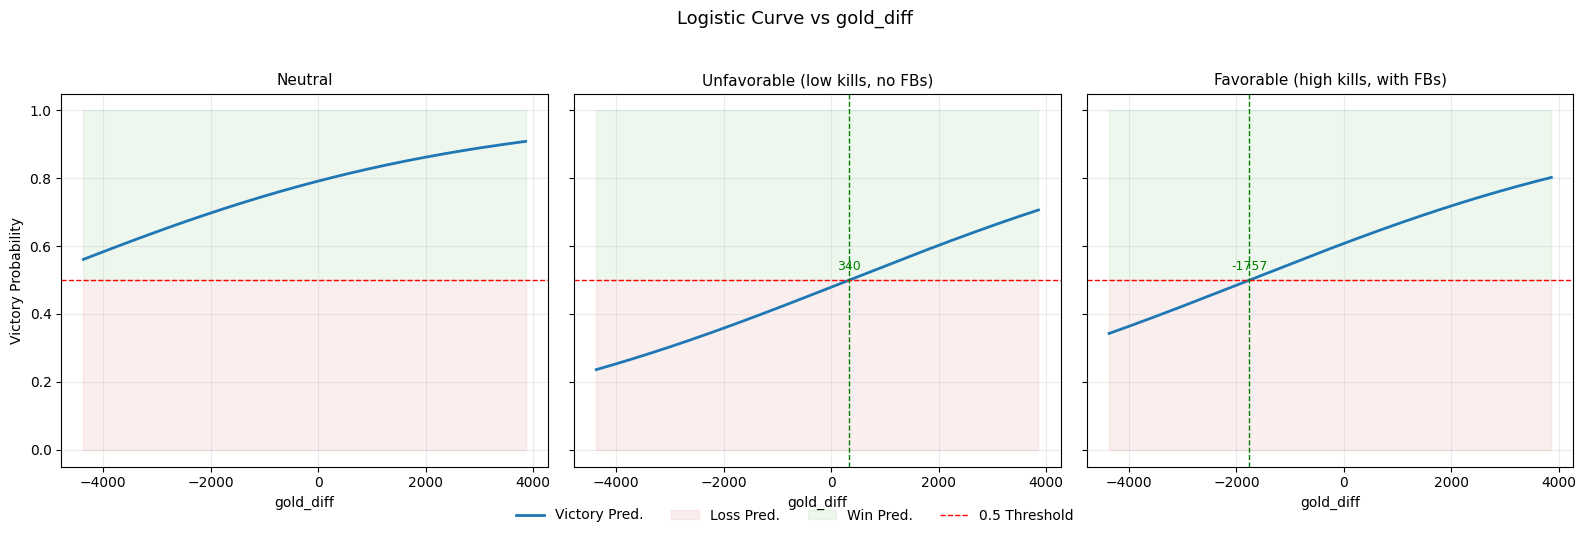

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Configuración base ===
feature_x = 'gold_diff'
features  = ['gold_diff','kill_diff','my_team_tower_fb','my_team_drake_fb','my_team_herald_fb']  # ajusta si difiere

# Punto de referencia (medianas en el espacio original)
ref_base = X_test[features].median().to_frame().T

# Rango de gold_diff para el barrido
qmin, qmax = X_test[feature_x].quantile([0.005, 0.995])
grid = np.linspace(qmin, qmax, 300)

# === Escenarios para las demás variables ===
# - Neutral: todo en mediana
# - Adverso: kills bajas (p25), sin FBs
# - Favorable: kills altas (p75), con FBs
scenarios = [
    ("Neutral", {}),
    ("Unfavorable (low kills, no FBs)", {
        'kill_diff': X_test['kill_diff'].quantile(0.25),
        'my_team_tower_fb': 0,
        'my_team_drake_fb': 0,
        'my_team_herald_fb': 0
    }),
    ("Favorable (high kills, with FBs)", {
        'kill_diff': X_test['kill_diff'].quantile(0.75),
        'my_team_tower_fb': 1,
        'my_team_drake_fb': 1,
        'my_team_herald_fb': 1
    }),
]

def predict_curve_for_scenario(name, overrides):
    # 1) referencia
    ref = ref_base.copy()
    for k, v in overrides.items():
        if k in ref.columns:
            ref.loc[:, k] = v

    # 2) grid
    grid_df = pd.concat([ref]*len(grid), ignore_index=True)
    grid_df[feature_x] = grid

    # 3) probas con el MISMO scaler y modelo
    grid_sc = scaler.transform(grid_df[features])
    p = model_enriched.predict_proba(grid_sc)[:, 1]

    # 4) umbral analítico p=0.5 (si existe y cae dentro del rango)
    w = model_enriched.coef_[0]
    b = model_enriched.intercept_[0]
    mu = scaler.mean_
    sg = scaler.scale_
    idx = features.index(feature_x)

    z_ref = (ref.iloc[0].values - mu) / sg
    K = np.dot(w, z_ref) - w[idx] * z_ref[idx]
    thr_x = None if np.isclose(w[idx], 0.0) else (mu[idx] - sg[idx]*(K + b)/w[idx])

    return p, thr_x, ref

# === Plot ===
fig, axes = plt.subplots(1, len(scenarios), figsize=(16, 5), sharey=True)

for ax, (name, overrides) in zip(axes, scenarios):
    p, thr_x, ref_used = predict_curve_for_scenario(name, overrides)

    # curva
    ax.plot(grid, p, label="Victory Pred.", lw=2)
    # bandas
    ax.fill_between(grid, 0, 0.5, color='tab:red', alpha=0.08, label="Loss Pred.")
    ax.fill_between(grid, 0.5, 1, color='tab:green', alpha=0.08, label="Win Pred.")
    # umbral horizontal
    ax.axhline(0.5, ls='--', c='red', lw=1, label = '0.5 Threshold')

    # línea vertical del umbral si cae dentro del rango
    if thr_x is not None and (grid.min() <= thr_x <= grid.max()):
        ax.axvline(thr_x, ls='--', c='green', lw=1)
        ax.text(thr_x, 0.52, f"{thr_x:.0f}", color='green', ha='center', va='bottom', fontsize=9)

    ax.set_title(name, fontsize=11)
    ax.set_xlabel('gold_diff')
    ax.grid(alpha=0.25)

axes[0].set_ylabel('Victory Probability')
# Leyenda compacta
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:4], labels[:4], loc="lower center", ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.02))

fig.suptitle("Logistic Curve vs gold_diff", fontsize=13, y=1.03)
plt.tight_layout()
plt.show()


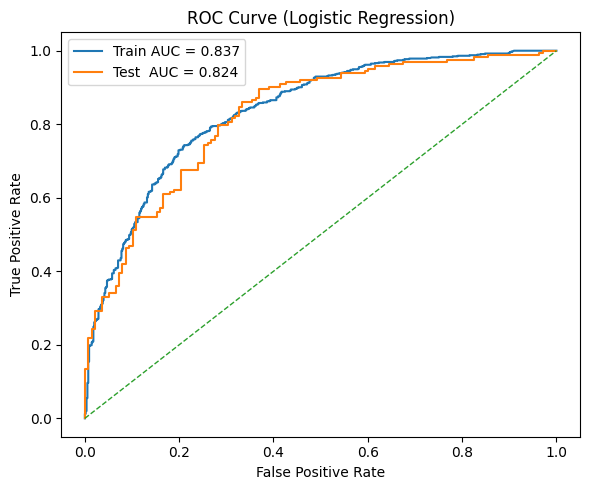

AUC (train): 0.8373 | AUC (test): 0.8237


In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilidades
y_proba_tr = model_enriched.predict_proba(X_train_scaled)[:, 1]
y_proba_te = model_enriched.predict_proba(X_test_scaled)[:, 1]

# ROC
fpr_tr, tpr_tr, _ = roc_curve(y_train, y_proba_tr)
fpr_te, tpr_te, _ = roc_curve(y_test,  y_proba_te)

auc_tr = roc_auc_score(y_train, y_proba_tr)
auc_te = roc_auc_score(y_test,  y_proba_te)

plt.figure(figsize=(6,5))
plt.plot(fpr_tr, tpr_tr, label=f"Train AUC = {auc_tr:.3f}")
plt.plot(fpr_te, tpr_te, label=f"Test  AUC = {auc_te:.3f}")
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Logistic Regression)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"AUC (train): {auc_tr:.4f} | AUC (test): {auc_te:.4f}")



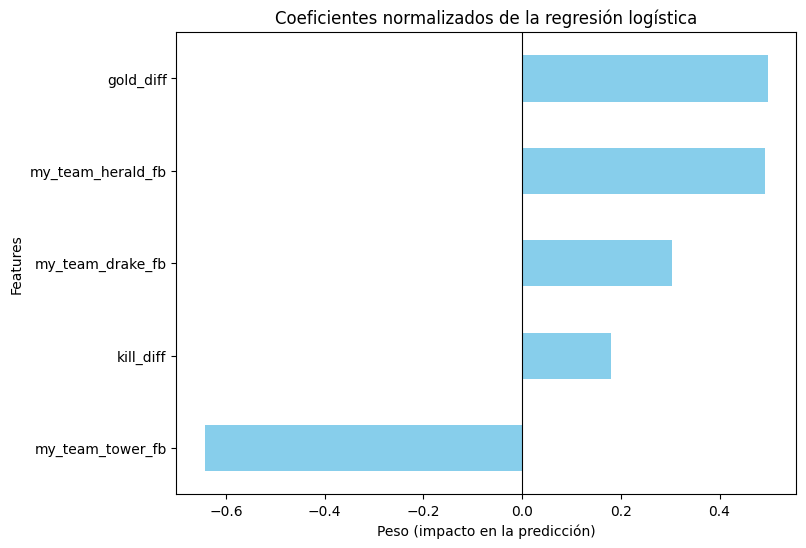

In [ ]:
# Coeficientes como Series
coef = pd.Series(model_enriched.coef_[0], index=X_train.columns)
coef_sorted = coef.sort_values()

# Plot
plt.figure(figsize=(8,6))
coef_sorted.plot(kind='barh', color="skyblue")
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Coeficientes normalizados de la regresión logística")
plt.xlabel("Peso (impacto en la predicción)")
plt.ylabel("Features")
plt.show()

In [ ]:

# Probabilidades predichas por el modelo
y_proba = model_enriched.predict_proba(X_test_scaled)[:, 1]

# Histograma normalizado (función de probabilidad empírica)
plt.figure(figsize=(6,4))
sns.histplot(y_proba, bins=20, kde=True, stat="density", color="skyblue", edgecolor="black")
plt.xlabel("Probabilidad de victoria predicha")
plt.ylabel("Densidad de probabilidad")
plt.title("Función de probabilidad de las predicciones")
plt.grid(True)
plt.show()
